In [20]:
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor, ICLDataPreprocessor
import pickle

import pandas as pd
import numpy as  np
import theano 
import scipy.signal as ss
import pymc3 as pm

In [17]:
%matplotlib inline
from matplotlib import pylab as plt

In [3]:
cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black"), # home
            ("\uf072", "grey"), # plane1
            ("\uf072", "black"), # plane2
            ("\uf238", "black"), # train
            ("\uf1b9", "black"), # car
            ("\uf641", "black") # flyer
        ]

In [70]:
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT", "AUT"),
    ("Albania", "AL", "ALB"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria", "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia", "EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Georgia", "GE", "GEO"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("Lithuania", "LT", "LTU"),
    ("Latvia", "LV", "LVA"),
    ("Malta", "MT", "MLT"),
    ("Morocco", "MA", "MAR"),
    ("Mexico", "MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Norway", "NO", "NOR"),
    ("New Zealand", "NZ", "NZL"),
    ("Poland", "PL", "POL"),
    ("Portugal", "PT", "PRT"),
    ("Romania", "RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA", "ZAF"),
]

region_info.sort(key=lambda x: x[0])
region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_threecode = list([x for _, _, x in region_info])


def eur_to_epi_code(x):
    if x in regions_threecode:
        return regions_epi[regions_threecode.index(x)]
    else:
        return "not found"




def process_euro_data(path, regular_data_path, ICL_data_path):
    dp = DataPreprocessor()
    data = dp.preprocess_data(regular_data_path)


    
    
    eur_df = pd.read_csv(path, parse_dates=["dateRep"], infer_datetime_format=True)
    eur_df['dateRep'] = pd.to_datetime(eur_df['dateRep'], utc=True)
    epi_codes = [eur_to_epi_code(cc) for cc in eur_df["countryterritoryCode"]]
    dti = pd.to_datetime(eur_df['dateRep'], utc=True)

    eur_df.index = pd.MultiIndex.from_arrays([epi_codes, dti])

    columns_to_drop = ["day", "month", "year", "countriesAndTerritories", "geoId", "popData2018", "continentExp",
                       "dateRep", "countryterritoryCode"]

    for col in columns_to_drop:
        del eur_df[col]

    eur_df = eur_df.loc[regions_epi]

    NewCases = np.zeros((len(data.Rs), len(data.Ds)))
    NewDeaths = np.zeros((len(data.Rs), len(data.Ds)))

    for r_i, r in enumerate(data.Rs):
        for d_i, d in enumerate(data.Ds):
            c_vals = eur_df.loc[r]
            if d in c_vals.index:
                NewCases[r_i, d_i] = c_vals["cases"].loc[d]
                NewDeaths[r_i, d_i] = c_vals["deaths"].loc[d]

    

    SmoothedNewCases = np.around(
        ss.convolve2d(NewCases, 1 / dp.N_smooth * np.ones(shape=(1, dp.N_smooth)), boundary="symm",
                      mode="same"))
    SmoothedNewDeaths = np.around(
        ss.convolve2d(NewDeaths, 1 / dp.N_smooth * np.ones(shape=(1, dp.N_smooth)), boundary="symm",
                      mode="same"))
    
    for r_i, r in enumerate(data.Rs):
        # if the country has too few deaths, ignore
        if data.Deaths[r_i, -1] < 50:
            print(f"EUR CDC Skipping smoothing {region_names[r_i]}")
            SmoothedNewDeaths[r_i, :] = NewDeaths[r_i, :]
    
    NewCases = SmoothedNewCases
    NewDeaths = SmoothedNewDeaths
    NewDeaths[NewDeaths < 0] = np.nan
    NewCases[NewCases < 0] = np.nan
    data.NewCases = np.ma.masked_invalid(NewCases.astype(theano.config.floatX))
    data.NewDeaths = np.ma.masked_invalid(NewDeaths.astype(theano.config.floatX))
    
    


    return data

dp = DataPreprocessor()
jh_data = dp.preprocess_data("../final_data/data_final.csv")
eur_data = process_euro_data("../final_data/eur_data.csv", "../final_data/data_final.csv", "../final_data/ICL.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.dat

EUR CDC Skipping smoothing Albania
EUR CDC Skipping smoothing Andorra
EUR CDC Skipping smoothing Estonia
EUR CDC Skipping smoothing Iceland
EUR CDC Skipping smoothing Latvia
EUR CDC Skipping smoothing Lithuania
EUR CDC Skipping smoothing New Zealand
EUR CDC Skipping smoothing Singapore
EUR CDC Skipping smoothing Slovakia


In [33]:

jhRs = [ jh_data.Rs.index(r) for r in eur_data.Rs]

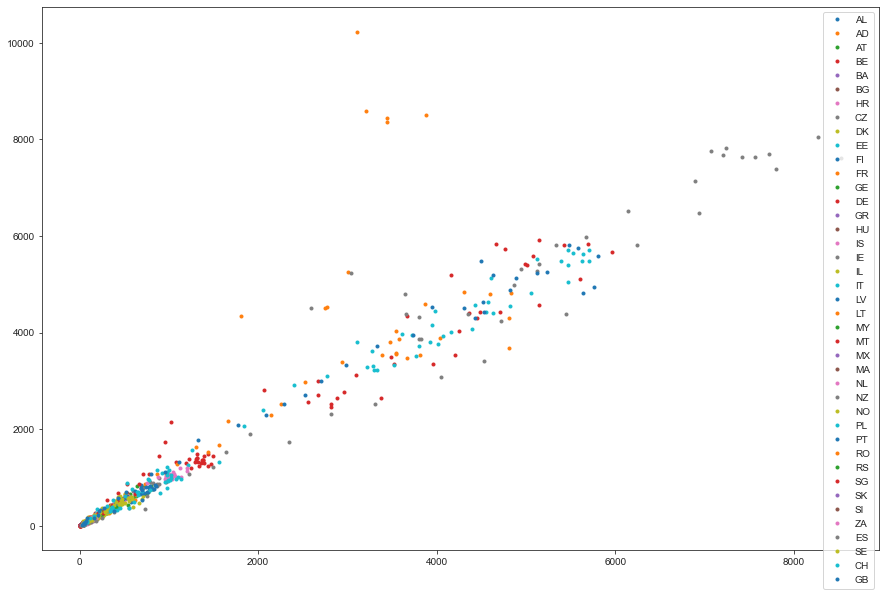

In [60]:


plt.figure(figsize=(15,10))

jh  = jh_data.NewCases[jhRs[:],:]
eur = eur_data.NewCases[:,:]
r = eur_data.Rs[:]

plt.plot(eur.T, jh.T, '.') ;
plt.legend(r)

In [36]:
jh_data.NewCases.shape

(41, 95)

In [37]:
eur_data.NewCases.shape

(41, 95)

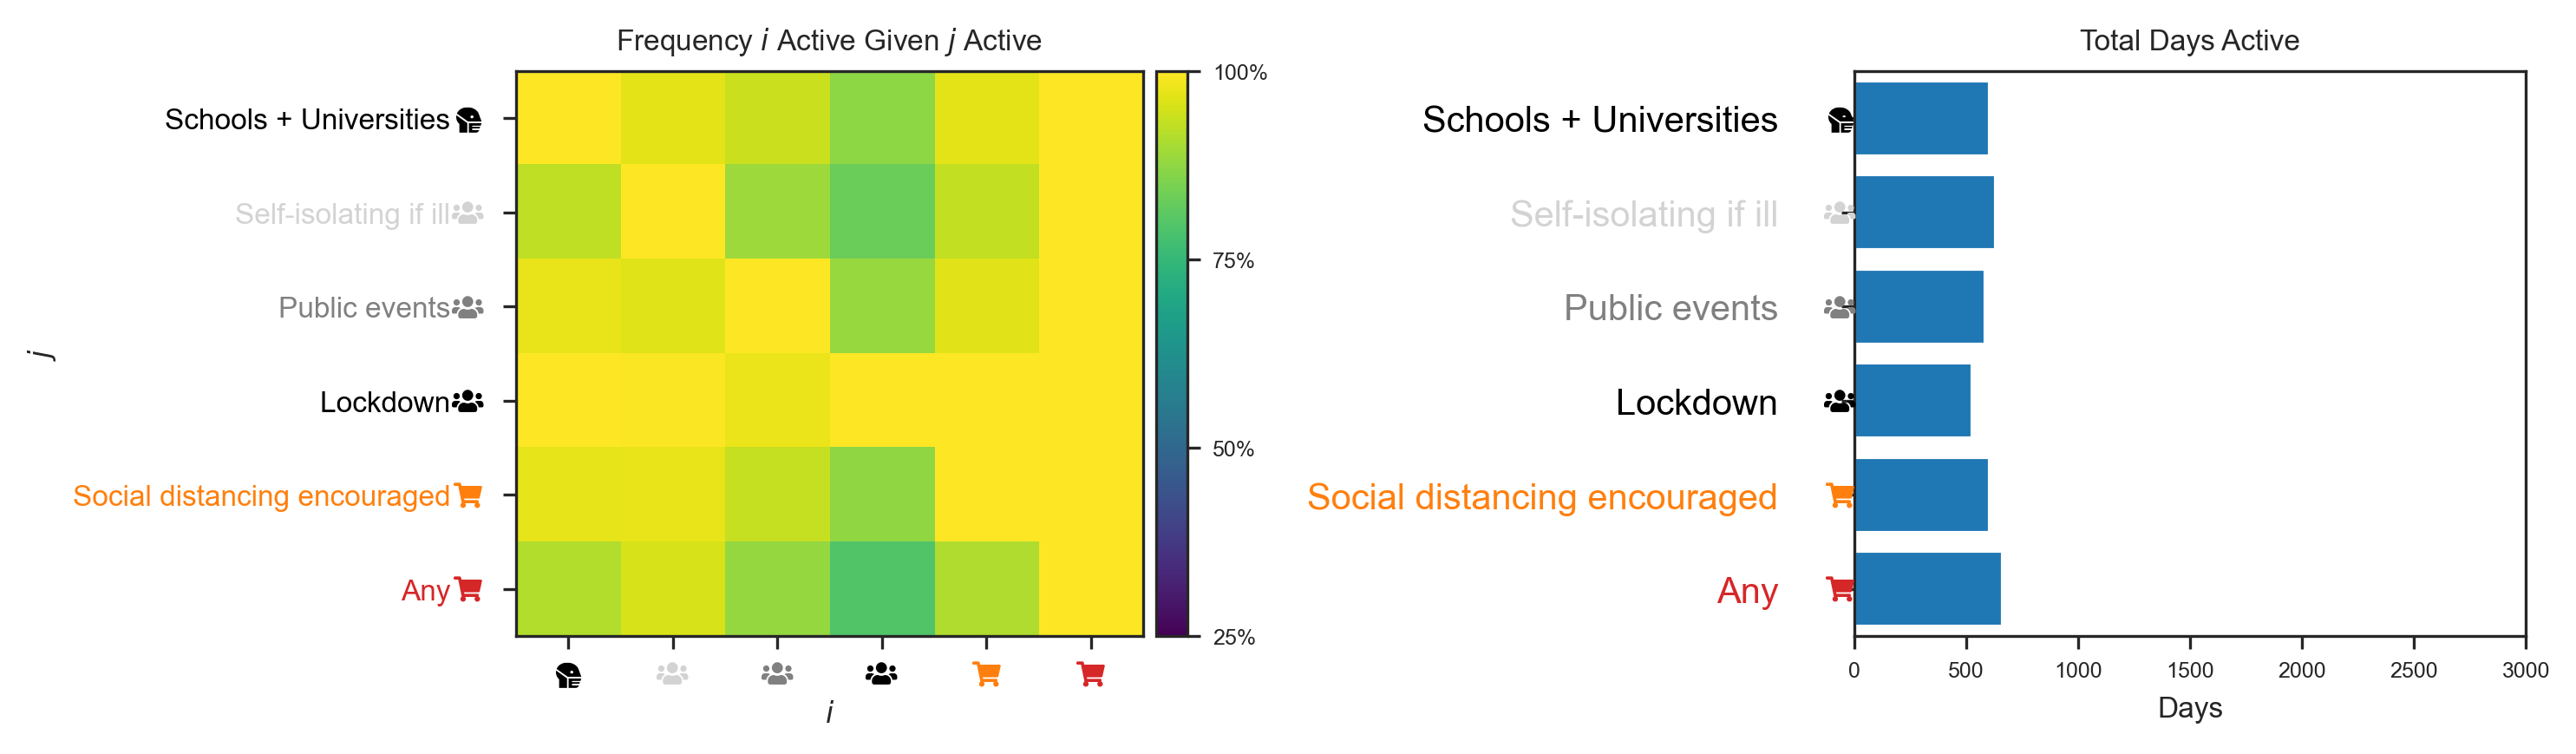

In [14]:
eur_data.summary_plot(cm_plot_style)

In [75]:
with cm_effect.models.CMCombined_Final(eur_data, cm_plot_style) as eur_model:
    eur_model.build_model()
with eur_model:
    eur_model.trace = pm.sample(500, cores=4, chains=1, max_treedepth=12)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeathsNoise, GrowthCasesNoise, RegionLogR_noise, HyperRVar, CM_Alpha]
INFO:pymc3:NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeathsNoise, GrowthCasesNoise, RegionLogR_noise, HyperRVar, CM_Alpha]
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [28:53<00:00,  1.73s/it] 
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [74]:
with eur_model:
    pm.save_trace(eur_model.trace, directory="small-eur")

In [62]:
with cm_effect.models.CMCombined_Final(jh_data, cm_plot_style) as jh_model:
    jh_model.build_model()
with jh_model:
    jh_model.trace = pm.sample(500, cores=4, chains=1, max_treedepth=12)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeathsNoise, GrowthCasesNoise, RegionLogR_noise, HyperRVar, CM_Alpha]
INFO:pymc3:NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeathsNoise, GrowthCasesNoise, RegionLogR_noise, HyperRVar, CM_Alpha]
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [32:37<00:00,  1.96s/it] 
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/science-revisions/out at 02-09;14-53
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/science-revisions/out at 02-09;14-53


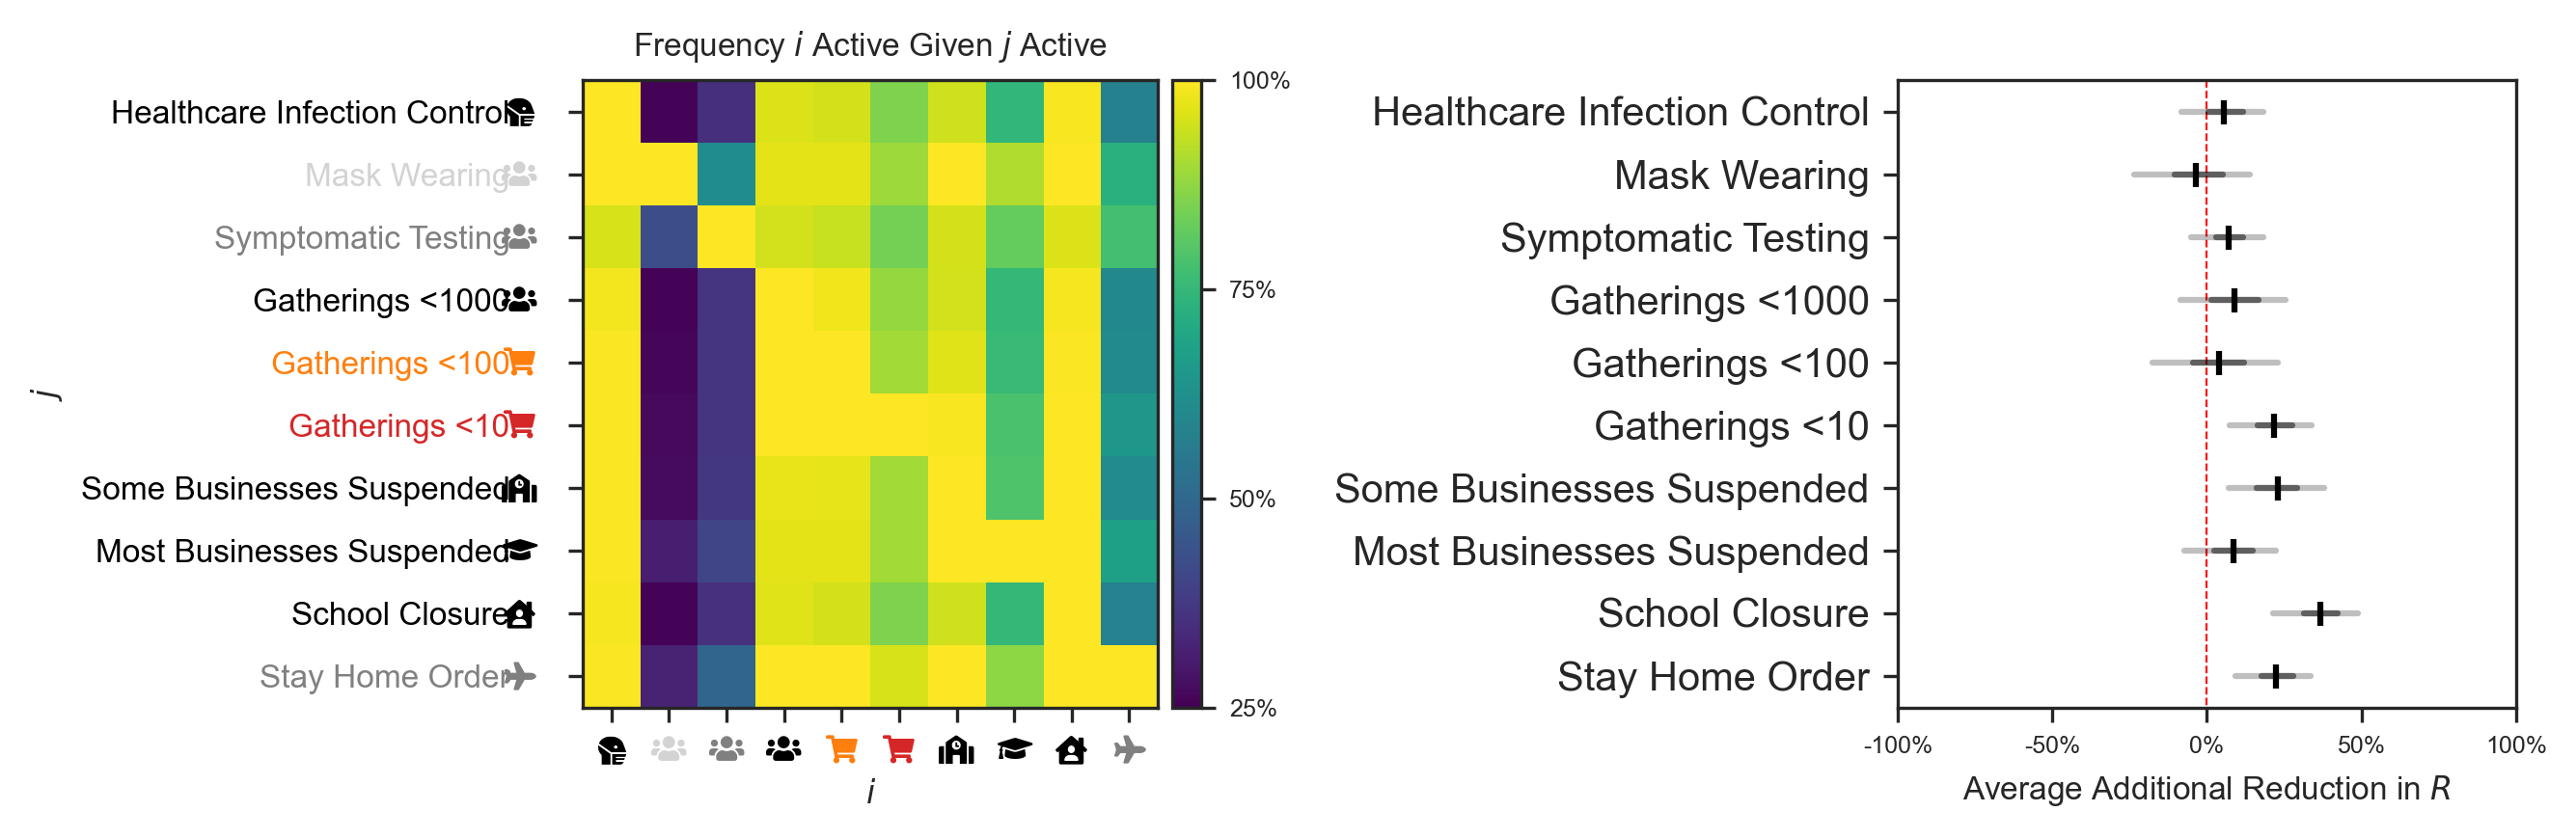

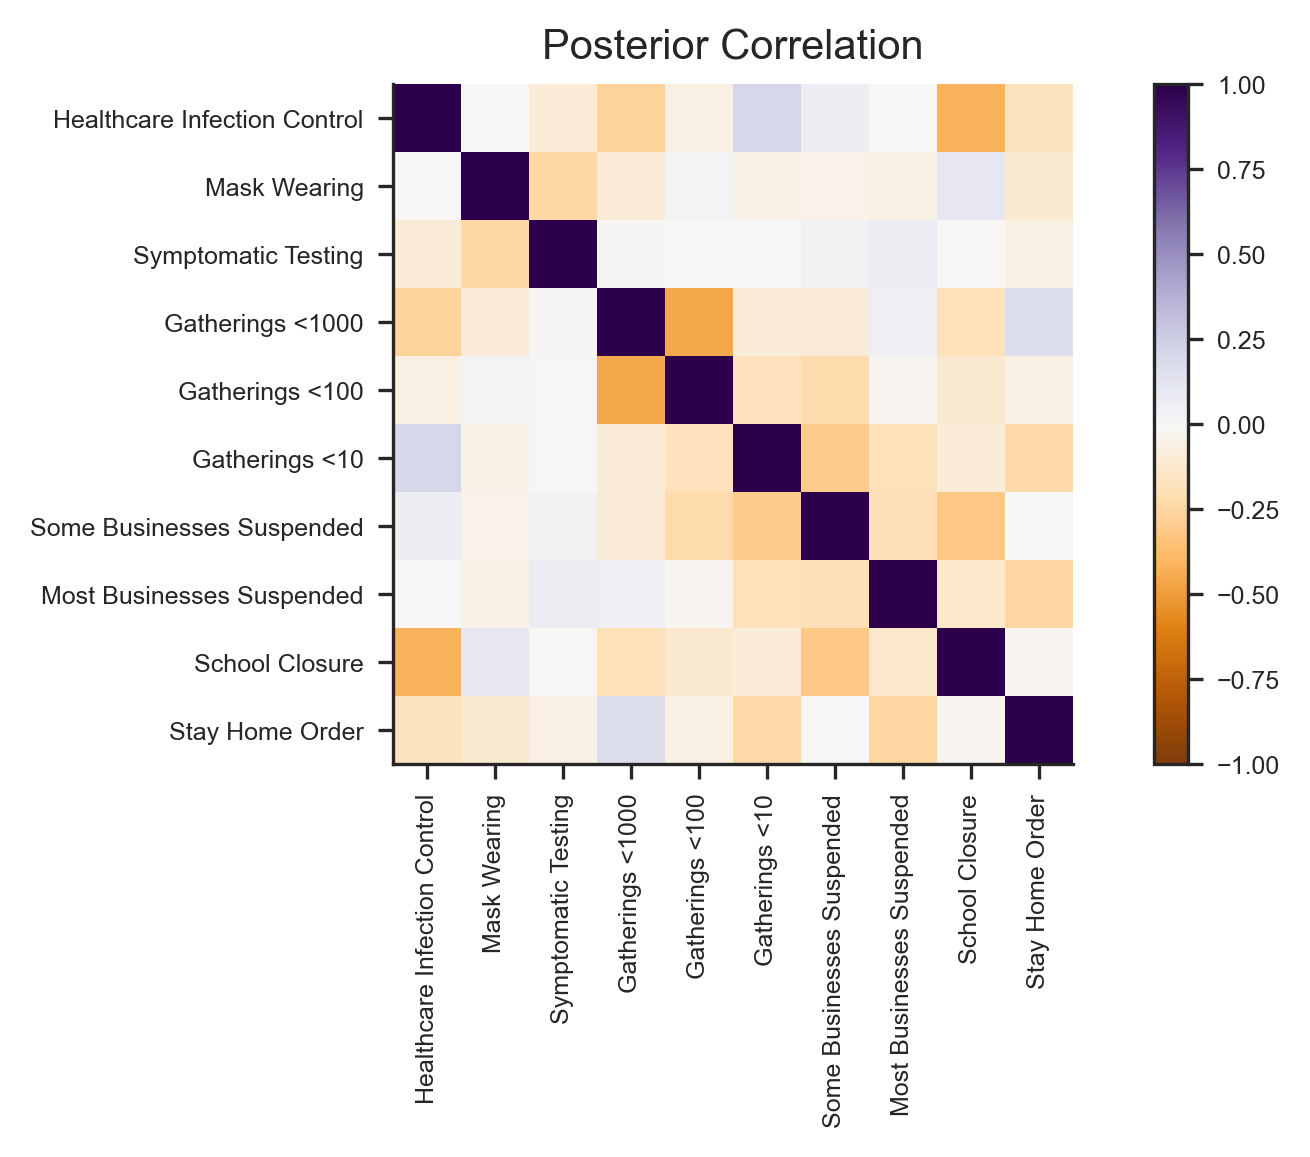

In [55]:
eur_model.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/science-revisions/out at 02-09;15-30
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/science-revisions/out at 02-09;15-30


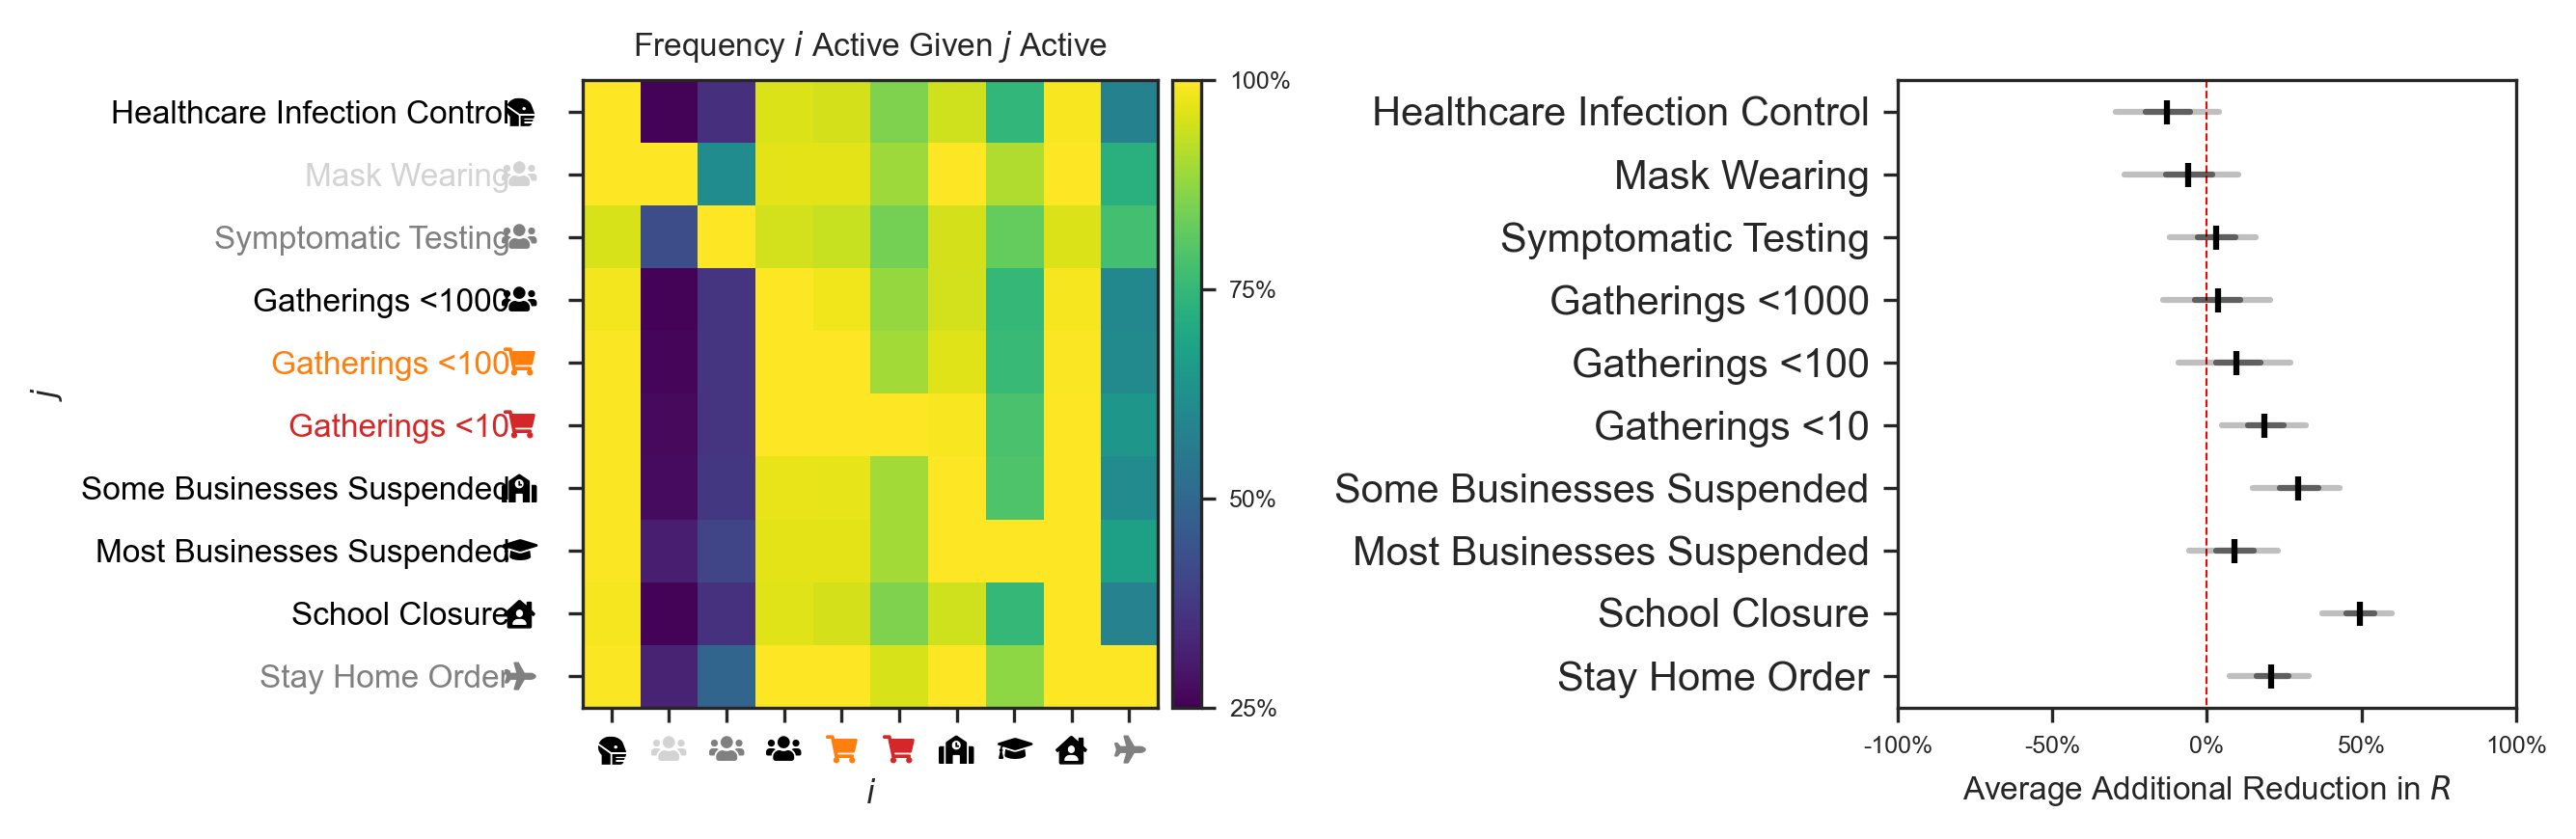

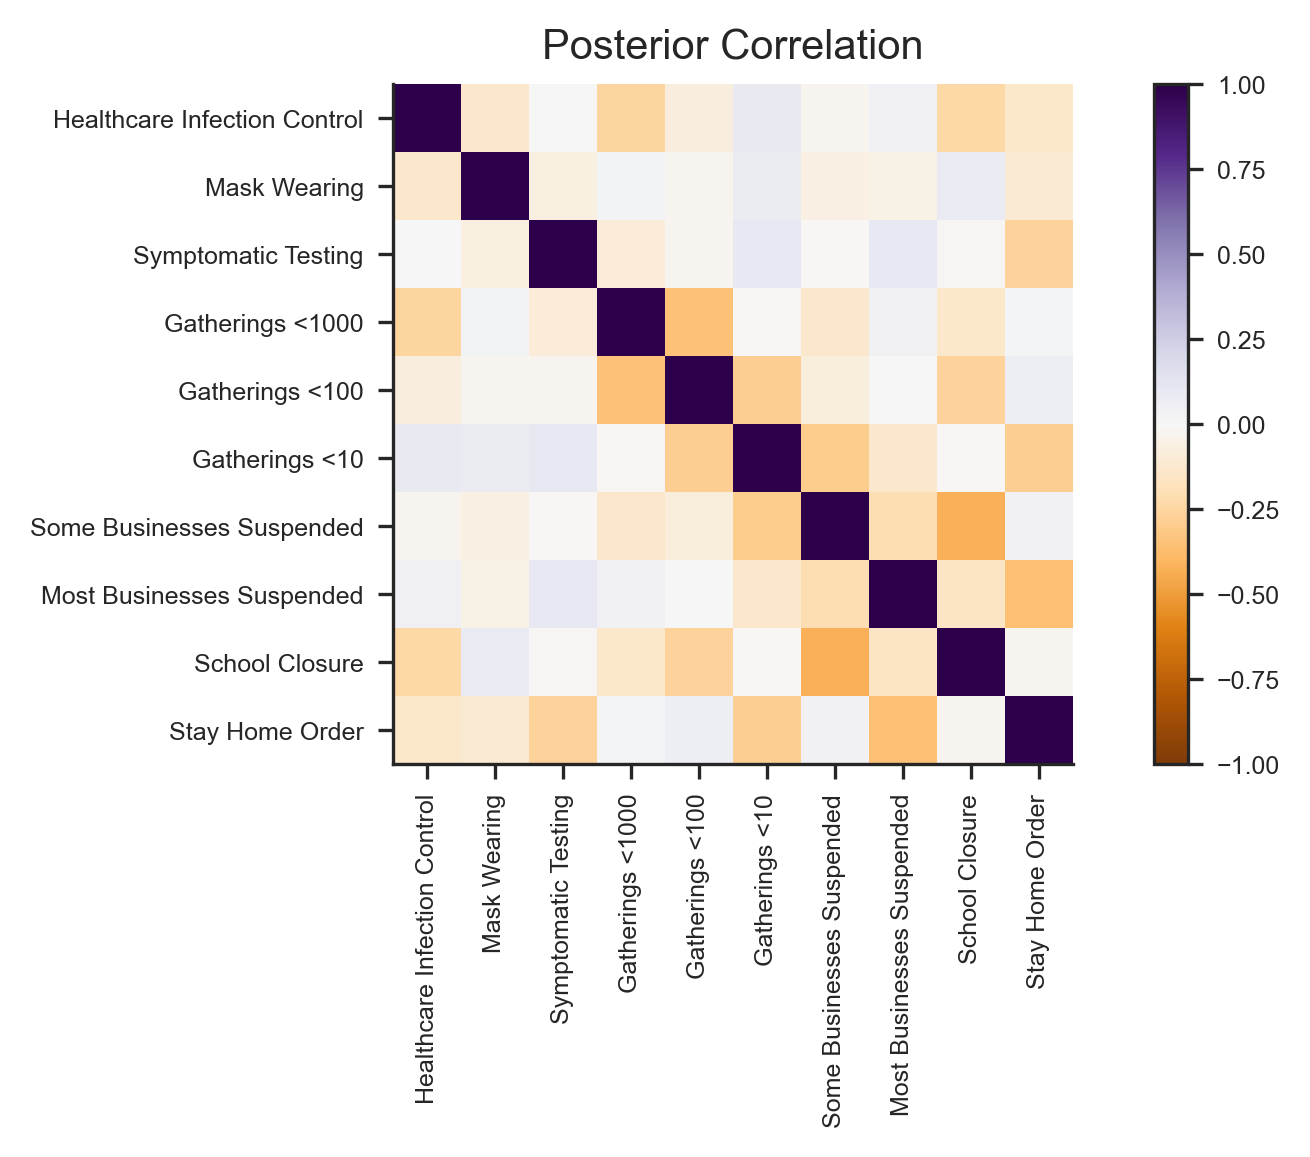

In [64]:
jh_model.plot_effect()

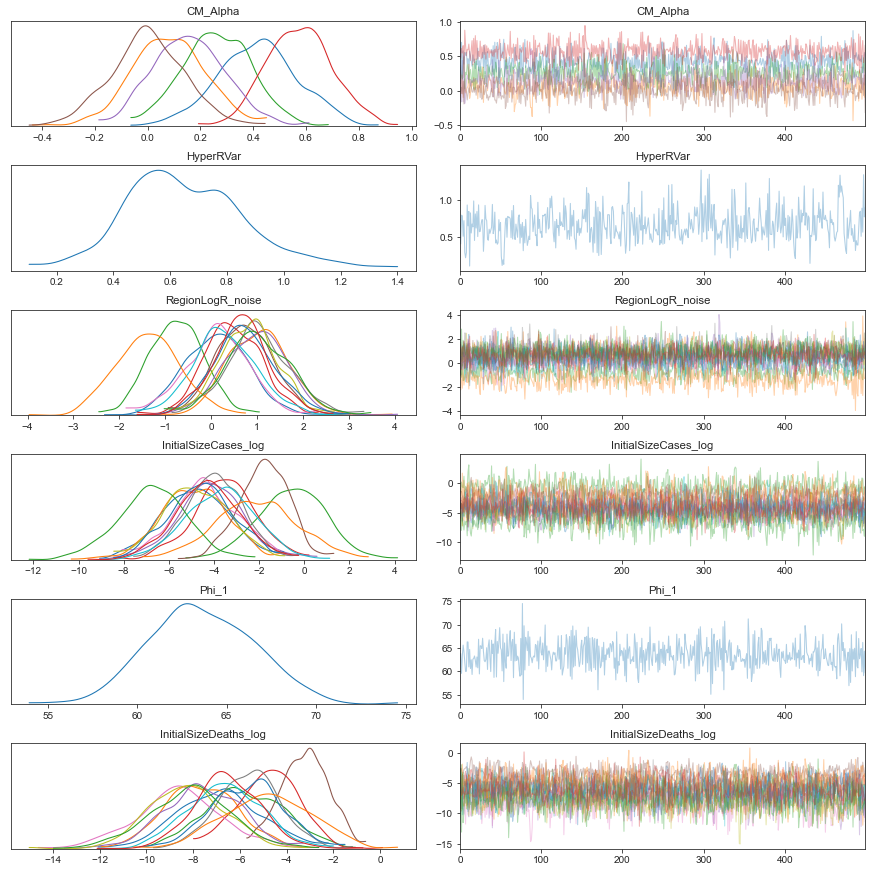

In [31]:
pvars = ['CM_Alpha',
 'HyperRVar',
 'RegionLogR_noise',
 'InitialSizeCases_log',
 'Phi_1',
 'InitialSizeDeaths_log']

with eur_model:
    pm.traceplot(eur_model.trace, var_names=pvars)

In [35]:
eur_data.NewCases.shape

(41, 95)

In [40]:
eur_data.ActiveCMs.shape

(41, 10, 95)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [47]:
c = eur_data.Rs.index('NZ')
eur_data.NewCases[c,:]


masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,
                   1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 3.0,
                   4.0, 6.0, 9.0, 12.0, 16.0, 23.0, 30.0, 42.0, 54.0,
                   63.0, 67.0, 73.0, 77.0, 62.0, 61.0, 59.0, 54.0, 45.0,
                   53.0, 44.0, 39.0, 34.0, 29.0, 25.0, 21.0, 19.0, 16.0,
                   13.0, 10.0, 7.0, 6.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0,
                   2.0, 3.0, 2.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
        

In [48]:
jh_data.NewCases[c,:]

masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 21.0, 36.0, 53.0, 70.0,
                   72.0, 77.0, 73.0, 68.0, 69.0, 71.0, 72.0, 78.0, 80.0,
                   73.0, 68.0, 58.0, 49.0, 41.0, 34.0, 28.0, 25.0, 21.0,
                   18.0, 16.0, 15.0, 13.0, 11.0, 9.0, 8.0, 7.0, 6.0, 6.0,
                   7.0, 7.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
      

In [50]:
len(region_info)

41

masked_array(
  data=[[--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 1.0, -2.0, 1.0],
        [--, --, --, ..., -1.0, 1.0, 6.0],
        ...,
        [--, --, --, ..., 0.0, 48.0, 35.0],
        [--, --, --, ..., 1.0, 16.0, 15.0],
        [--, --, --, ..., -57.0, 98.0, -25.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)

In [63]:
eur_raw = pd.read_csv("../final_data/eur_data.csv", parse_dates=["dateRep"], infer_datetime_format=True)

In [65]:
eur_raw

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-06-15,15,6,2020,664,20,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-06-14,14,6,2020,556,5,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-06-13,13,6,2020,656,20,Afghanistan,AF,AFG,37172386.0,Asia
3,2020-06-12,12,6,2020,747,21,Afghanistan,AF,AFG,37172386.0,Asia
4,2020-06-11,11,6,2020,684,21,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...
23632,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
23633,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
23634,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
23635,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


In [67]:
eur_raw.countriesAndTerritories.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czechia',
       'Democratic_Republic_of_the_Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Eri

In [73]:
pm.save_trace?